## Predicting outcome of League of Legend Ranked games in ChampSelect


League of Legends is a multiplayer online battle arena (MOBA) game
Two teams of five players compete to destroy an enemy building called a Nexus.
Before each game, the player select their champions and once everything is locked, play the game.


Goal : 
- Is this game likely to be a win ? or should I dodge given my teamates picks and recents games ?
- What are the key feature to look prior a game





## Acquire, Prepare, Analyse, Report, Act

In this Machine Learning project I'll present the full process, from getting the data to how to act on the result we obtained by training our models


### Acquire

My choice of feature is key in the way I want to acquire data.

Feature selected : 

- Winrate of the player on his champion pick
- Number of game played with this champion
- Number of win over the last 2 games - Metric checking if the player is in the right state of mind
- Number of win over the last 5 games - Metric checking the overall trend on the player mindset
- Experience of this player with his pick
- MMR, Which is his rank on the competitive ladder (like ELO on chess)
- Number of game played during the last week - Metric checking if the player is casual

Now where to get all these informations ?

- Riot API's store the information regarding the games, player experience and more
- OP.GG store the information about player profile

Given the architecture of Riot API, which is in a diplomatic way of saying things, a challenge, I chained several API call per games in order to get the correct information.

Here is the logic behind :

1- get the player name
2- get the list of games he played during the last week
3- loop over this list and get information about the result, champ played , list of teammates
4- for each teammate, get their 5 last games, result, experience (30 api call per game)
5- store all the information in MongoDB
6- select a random teammate and restart the whole process

Once all set of games have been retrieved, and as it's not possible with Riot Api to get the winrate of champion per player, we do some web scrapping on OP.GG to get the stats for each player.
This will allow us to get the winrate for each champion per player

We end up with 2 collection in our MongoDB

- Matches
- Winrate











### ,;






In [17]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from bson.json_util import dumps, loads
from pandas.io.json import json_normalize

client = MongoClient('mongodb://localhost:27017/')
dbmongo = client["MetAnalyser"]
collection = dbmongo["Matches"]
cursor = collection.find()

scrapycollection = dbmongo["scrapy"]

matrix = []
for document in cursor:
    feature = []
    for k in ['Top', 'Jungle', 'Mid', 'ADC', 'Support']:
        wr = 0.5
        nbplayed = 5
        kda = 1.5
        champ = document[k]["champ"]
        matchup = document[k]["matchup"]
        lastweek = document[k]["totalgames"]
        mmr = document[k]["mmr"]
        championwinrate = scrapycollection.find({"player": document[k]["player"]})
        for doc in championwinrate:
            try:
                wr = doc["stats"][champ]["winrate"]
                wr = 0.5     # default to disqualify this lookahead feature
                nbplayed = doc["stats"][champ]["nplayed"]
                kda = doc["stats"][champ]["kda"]
            except:
                wr = 0.5
                nbplayed = 5
                kda = 1.5
        try:
            exp = document[k]["masteries"][champ]
        except:
            exp = 2000
        # print("Position : {} - {} vs {} - exp : {} - wr : {} over {} games".format(k, champ, matchup, exp, wr, nbplayed))

        if document[k]["history"] == "No games":
            continue
        df_last5 = pd.DataFrame(document[k]["history"]).T  # getting all the match history of teammates
        df_last2 = pd.DataFrame(document[k]["history"]).T.head(2)
        winlast5 = df_last5[df_last5['result'] == 'Win'].groupby('result').size()
        winlast2 = df_last2[df_last2['result'] == 'Win'].groupby('result').size()
        if not len(winlast5) == 0:
            winlast5 = df_last5[df_last5['result'] == 'Win'].groupby('result').size().iloc[0]
        else:
            winlast5 = 0
        if not len(winlast2) == 0:
            winlast2 = df_last2[df_last2['result'] == 'Win'].groupby('result').size().iloc[0]
        else:
            winlast2 = 0
        featureplayer = [wr, nbplayed, winlast2, winlast5, exp, mmr, lastweek]
        feature = np.hstack((feature, featureplayer)).ravel()
    if len(feature) == 35:
        feature = np.hstack((feature, document["result"] * 1)).ravel()
        matrix.append(feature)

### Explore


In [18]:
EDA = pd.DataFrame(data=matrix) #full data
pd.options.display.max_columns = None
EDA.columns = ["TOP.Winrate","TOP.NbGames","TOP.WinLast2","TOP.WinLast5","TOP.Exp","TOP.MMR","TOP.LastWeek","JUN.Winrate","JUN.NbGames","JUN.WinLast2","JUN.WinLast5","JUN.Exp","JUN.MMR","JUN.LastWeek","MID.Winrate","MID.NbGames","MID.WinLast2","MID.WinLast5","MID.Exp","MID.MMR","MID.LastWeek","BOT.Winrate","BOT.NbGames","BOT.WinLast2","BOT.WinLast5","BOT.Exp","BOT.MMR","BOT.LastWeek","SUP.Winrate","SUP.NbGames","SUP.WinLast2","SUP.WinLast5","SUP.Exp","SUP.MMR","SUP.LastWeek","Result"]
EDA.head()

,TOP.Winrate,TOP.NbGames,TOP.WinLast2,TOP.WinLast5,TOP.Exp,TOP.MMR,TOP.LastWeek,JUN.Winrate,JUN.NbGames,JUN.WinLast2,JUN.WinLast5,JUN.Exp,JUN.MMR,JUN.LastWeek,MID.Winrate,MID.NbGames,MID.WinLast2,MID.WinLast5,MID.Exp,MID.MMR,MID.LastWeek,BOT.Winrate,BOT.NbGames,BOT.WinLast2,BOT.WinLast5,BOT.Exp,BOT.MMR,BOT.LastWeek,SUP.Winrate,SUP.NbGames,SUP.WinLast2,SUP.WinLast5,SUP.Exp,SUP.MMR,SUP.LastWeek,Result
0,0.5,5.0,1.0,3.0,17212.0,1200.0,78.0,0.5,5.0,0.0,2.0,26510.0,1216.0,64.0,0.5,5.0,0.0,2.0,136011.0,1216.0,6.0,0.5,5.0,0.0,0.0,106676.0,1217.0,20.0,0.5,5.0,1.0,3.0,90383.0,1200.0,34.0,1.0
1,0.5,5.0,1.0,1.0,2000.0,1113.0,31.0,0.5,5.0,1.0,2.0,47011.0,1216.0,63.0,0.5,5.0,1.0,3.0,19330.0,1100.0,41.0,0.5,5.0,1.0,2.0,2000.0,1121.0,18.0,0.5,5.0,1.0,3.0,244117.0,1032.0,63.0,0.0
2,0.5,5.0,2.0,4.0,32921.0,1100.0,24.0,0.5,5.0,0.0,2.0,70146.0,1100.0,11.0,0.5,5.0,1.0,2.0,2000.0,1100.0,44.0,0.5,5.0,1.0,3.0,80372.0,1100.0,23.0,0.5,5.0,1.0,2.0,94370.0,1101.0,43.0,0.0
3,0.5,5.0,2.0,4.0,2000.0,964.0,4.0,0.5,5.0,2.0,5.0,2000.0,1100.0,7.0,0.5,5.0,1.0,1.0,7119.0,1108.0,2.0,0.5,5.0,1.0,2.0,32688.0,1100.0,43.0,0.5,5.0,2.0,5.0,2000.0,1173.0,64.0,0.0
4,0.5,5.0,1.0,1.0,977106.0,1259.0,48.0,0.5,5.0,2.0,3.0,2000.0,1241.0,91.0,0.5,5.0,2.0,3.0,2000.0,1271.0,31.0,0.5,5.0,0.0,2.0,2000.0,1121.0,19.0,0.5,5.0,1.0,2.0,43936.0,1103.0,44.0,0.0


Note: you may need to restart the kernel to use updated packages.


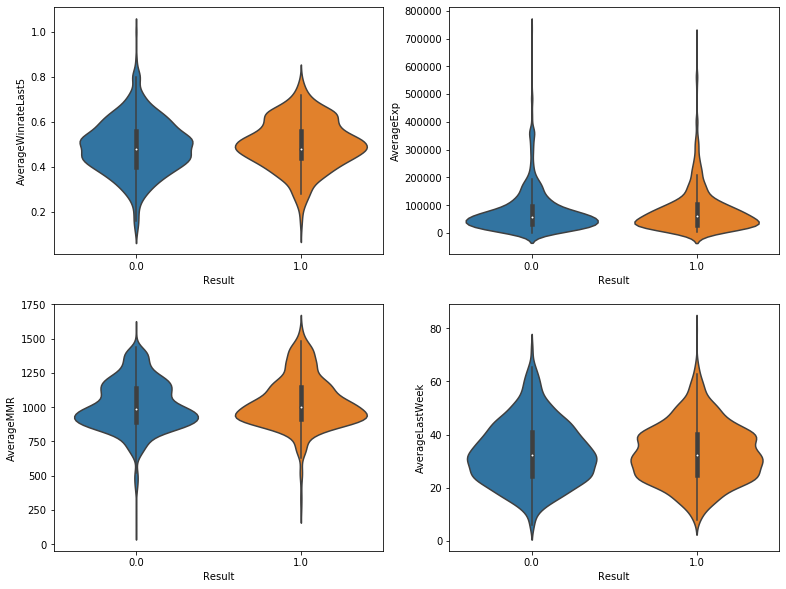

In [20]:
EDA["AverageWinrateLast2"] = (EDA["TOP.WinLast2"]+EDA["JUN.WinLast2"]+EDA["MID.WinLast2"]+EDA["BOT.WinLast2"]+EDA["SUP.WinLast2"])/10
EDA["AverageWinrateLast5"] = (EDA["TOP.WinLast5"]+EDA["JUN.WinLast5"]+EDA["MID.WinLast5"]+EDA["BOT.WinLast5"]+EDA["SUP.WinLast5"])/25
EDA["AverageExp"] = (EDA["TOP.Exp"]+EDA["JUN.Exp"]+EDA["MID.Exp"]+EDA["BOT.Exp"]+EDA["SUP.Exp"])/5
EDA["AverageLastWeek"] = (EDA["TOP.LastWeek"]+EDA["JUN.LastWeek"]+EDA["MID.LastWeek"]+EDA["BOT.LastWeek"]+EDA["SUP.LastWeek"])/5
EDA["AverageMMR"] = (EDA["TOP.MMR"]+EDA["JUN.MMR"]+EDA["MID.MMR"]+EDA["BOT.MMR"]+EDA["SUP.MMR"])/5

EDA.head()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2,figsize=(13, 10))
sns.violinplot(ax=ax[0, 0],x="Result", y="AverageWinrateLast5", data=EDA)
sns.violinplot(ax=ax[1, 0],x="Result", y="AverageMMR", data=EDA)
sns.violinplot(ax=ax[0, 1],x="Result", y="AverageExp", data=EDA)
sns.violinplot(ax=ax[1, 1],x="Result", y="AverageLastWeek", data=EDA)
plt.show()




### Analyse


I will use __Sklearn__ library to estimate my models

### <u>Logistic Regression (LR) :</u>
Used to model the probability of a certain class event.
The model works by predicting the probability that Y belongs to a particular category by first fitting the data to a linear regression model which is then passed to the sigmoid function. If the probability is higher than a predetermined threshold (usually P(Yes)>0.5) then the model will predict Yes (1)

__Sigmoid function :__

$ g(z) = \frac{1}{(1+e^{-z})}$

g(0) = 0.5 -> S-Shaped curve

The best coefficient are found using gradient descent to optimize the cost function

__Cost function :__

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))]$

__Gradient :__


$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$

__Gradient Descent :__

for i in range(num_iters):
    $\Theta = \Theta - (\alpha * grad)$
    
will give optimized theta

__Decision boundary :__

hypersurface that partitions the underlying vector space into two sets, one for each class

$h_\Theta(x) = g(z)$, where g is the sigmoid function and $z = \Theta^Tx$

Since $h_\Theta(x) \geq 0.5$ is interpreted as predicting class \"1\" 

$g(\Theta^Tx) \geq 0.5$ or $\Theta^Tx \geq 0$ predict class \"1\"
    
$\Theta^Tx  = 0$ is the decision boundary

__Prediction :__

Prediction = $x*\Theta$

### <u>Random Forest Classifier (RFC) :</u>

__Decision Trees__

Binary branching tructure used to classify an arbitrary input vector X. Each node in the tree contains a simple feature comparison against some field.
Result of each comparairison is either true or false, which determines if we should proceed along the left or right side of the given node.
Models rarely just use one decision tree. instead they aggregate many decision trees using methods like ensembling, bagging, and boosting.


__Ensemble Learning:__

Strategy of combining many different classifiers/models into one predictive model. It revolves around the idea of voting - "Wisdom of crowds" approach. The most predicted class will be the final prediction.

__Bagging :__

Ensemble method that works by taking B bootstrapped subsamples of the training data and constructing B trees, each tree training on a distinct subsample.
We build many independent predictors and combine them using some model averaging technique. We take random sub sample/bootstrap of data for each model so that all the models are little different from each other.Each observation is chosen with replacement to be used as input for each of the model.


__Random Forest Classifier__ is buid on bagging by decorrelating the trees. When building the trees, everytime we consider a split, a random sample of the p predictors is chosen as split candidates, not the full set (typically m=SQRT(p)). When m=p we are just doing bagging


### <u>Gradient Boosting (GBC) :</u>

__Boosting :__

The main idea is to improve our model where it is not performing well by using information from previously constructed classifiers. Slow Learner. it has 3 tunning parameters
- Number of classifiers B
- Learning parameter $\lambda$
- Interaction depth d which controls interaction order of model

In GB, the objective is to minimize the MSE (mean square error)


### <u>Multi-layer perceptron (MLPC) :</u>

### <u>GridSearchCV vs StandardizedCV :</u>




In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

def LR():
    params = {'C':np.linspace(0.01,5,10),
            'solver':['newton-cg','lbfgs','liblinear','sag','saga']}
    model = LogisticRegression(max_iter=1000, random_state=189)
    return model, params


def RFC():
    params =  {}
    model = RandomForestClassifier()
    return model, params


def GBC():
    params = {'n_estimators':range(10, 300, 50), 'learning_rate':np.linspace(0.001, 0.1, 5),
        'max_depth':range(1, 30, 4), 'min_samples_leaf':range(1, 30, 4)}
    model = GradientBoostingClassifier(min_samples_split=15,max_features='sqrt',
                                       subsample=0.8,random_state=189)
    return model, params

def MLPC():
    model = MLPClassifier(random_state=189, max_iter=1000)
    params = {'hidden_layer_sizes':[(100), (100, 100), (50, 100), (100, 50), (100, 100, 100),
                                    (50, 100, 50), (100, 50, 100), (100, 100, 50), (50, 50, 100),
                                    (100, 100, 100, 100), (100, 50, 100, 50), (50, 100, 50, 100),
                                    (100, 100, 100, 100, 100), (100, 50, 100, 50, 100),
                                    (50, 100, 50, 100, 50), (100, 100, 50, 100, 100),
                                    (100, 100, 100, 100, 100, 100), (100, 100, 100, 100, 100, 100, 100),
                                    (80, 70, 60, 50, 40, 30, 20, 10), (200, 150, 100, 50, 20),
                                    (120, 90, 75, 63, 55, 50)],
              'activation':['relu', 'tanh'], 'alpha':np.linspace(0.000001, 0.001, 10)}
    return model, params

def SVC():
    params = {'C':np.linspace(0.01,5,25), 'kernel':['linear','poly','rbf','sigmoid']}
    model = SVC()
    return model, params


In [22]:
import time
import pylab as pl
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import datetime
import sys
sys.setrecursionlimit(100000)

%matplotlib inline



def getdata(matrix,gamenumber=50,split_percent=0.7,scale=True):

    df = pd.DataFrame(data=matrix) #full data
    df = df.sample(gamenumber) #randomly select subset of data
    data = df.values
    np.random.shuffle(data)

    breakpoint = int(split_percent*len(data))
    Xtrain =  data[0:breakpoint,:-1]
    Xtest = data[breakpoint:,:-1]
    Ytrain = data[0:breakpoint,-1].T.astype(float)
    Ytest = data[breakpoint:,-1].T.astype(float)

    #c
    if scale==True:
        xScaler = StandardScaler()
        xScaler.fit(Xtrain)
        Xtrain = xScaler.transform(Xtrain)
        Xtest = xScaler.transform(Xtest)

    return Xtrain,Xtest,Ytrain,Ytest


def train_modelGSC(model,params,Xtrain,Ytrain):
    gridsearch = GridSearchCV(estimator = model, param_grid = params, n_jobs=-1)
    gridsearch.fit(Xtrain,Ytrain)
    return gridsearch.cv_results_["mean_test_score"], gridsearch.best_params_, gridsearch.cv_results_["std_test_score"]

def train_modelRSC(model,params,Xtrain,Ytrain):
    randomizedsearch = RandomizedSearchCV(estimator = model, param_distributions = params, n_jobs=-1)
    randomizedsearch.fit(Xtrain,Ytrain)
    return randomizedsearch.cv_results_["mean_test_score"], randomizedsearch.best_params_, randomizedsearch.cv_results_["std_test_score"]


In [23]:
def accuracy(steps=20):
    #model_list = ['LR','RFC','GBC','MLPC','SVC']
    model_list = ['LR','RFC','GBC','MLPC']
    #model_list = ['RFC','GBC']
    total_sets = len(matrix)
    maxrange = total_sets/steps
    learningcurves = {}
    for j in range(1,int(maxrange)-1):
        result={}
        for mod in model_list:
            #print("Training Model : {}  - Time : {}".format(mod, datetime.datetime.now()))
            Xtrain, Xtest, Ytrain, Ytest = getdata(matrix,gamenumber=j*steps)
            if mod == "LR" :
                model, params = LR()
            elif mod == "RFC" :
                model, params = RFC()
            elif mod == "GBC":
                model, params = GBC()
            elif mod == "MLPC":
                model, params = MLPC()
            elif mod == "SVC":
                model, params = SVC()
            #meanscore, best_params, stdscore = train_modelGSC()model, params, Xtrain, Ytrain
            meanscore, best_params, stdscore = train_modelRSC(model, params, Xtrain, Ytrain)
            model.set_params(**best_params)
            model.fit(Xtrain,Ytrain)
            y_pred = [i for i in model.predict(Xtest)]
            val_accuracy = sum([1 if i == j else 0 for i, j in zip(y_pred, Ytest)])/len(y_pred)
            val_error = sum([0 if i == j else 1 for i, j in zip(y_pred, Ytest)])/len(y_pred)
            #print(val_error)
            #print("Model : {}  - M : {} - Accuracy : {} - Time : {}".format(mod, j*steps, round(val_accuracy,2), datetime.datetime.now()))
            result[mod] = val_accuracy
        learningcurves[j*steps] = {'LR' : result['LR'],'RFC' : result['RFC'],'GBC' : result['GBC'],'MLPC' : result['MLPC']}
        #learningcurves[j*steps] = {'RFC' : result['RFC'],'GBC' : result['GBC']}
    return learningcurves
        
learningcurves = accuracy(50)



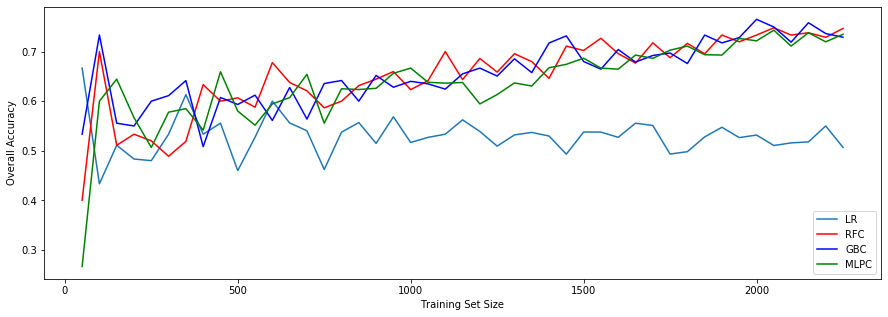

In [31]:
df = pd.DataFrame.from_dict(learningcurves, orient='index')

plt.figure(figsize=(15,5))

ax = plt.gca()

df.reset_index().plot(kind='line',x='index',y='LR',ax=ax)
df.reset_index().plot(kind='line',x='index',y='RFC', color='red', ax=ax)
df.reset_index().plot(kind='line',x='index',y='GBC', color='blue', ax=ax)
df.reset_index().plot(kind='line',x='index',y='MLPC', color='green', ax=ax)
#display.display(plt.gcf())
plt.xlabel("Training Set Size")
plt.ylabel("Overall Accuracy")

pd.DataFrame.from_dict(data=learningcurves, orient='index').to_csv('dict_file.csv', header=True)
    

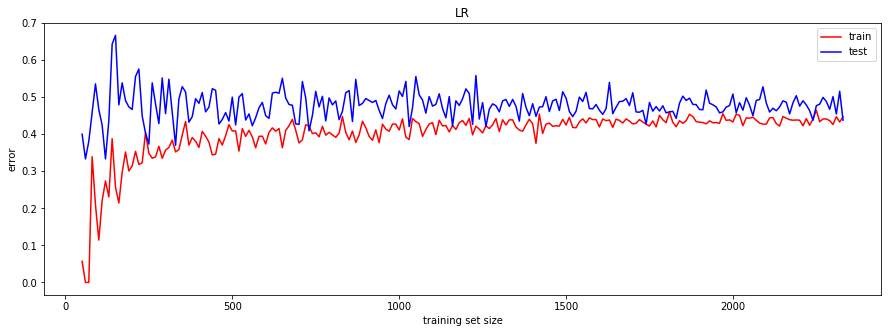

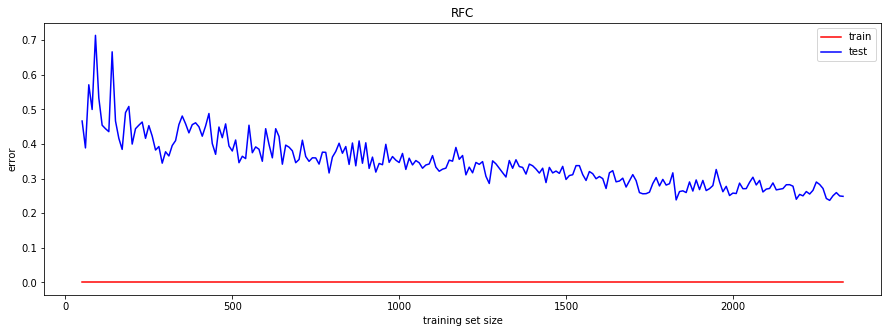

In [25]:
def learningcurves_2(steps=20, mod="LR"):
    total_sets = len(matrix)
    maxrange = total_sets/steps
    learningcurves = {}
    result={}
    for j in range(5,int(maxrange)-1):
        #print("Training Model : {}  - Time : {}".format(mod, datetime.datetime.now()))
        Xtrain, Xtest, Ytrain, Ytest = getdata(matrix,gamenumber=j*steps)
        if mod == "LR" :
            model, params = LR()
        elif mod == "RFC" :
            model, params = RFC()
        elif mod == "GBC":
            model, params = GBC()
        elif mod == "MLPC":
            model, params = MLPC()
        elif mod == "SVC":
            model, params = SVC()
        #meanscore, best_params, stdscore = train_modelGSC()model, params, Xtrain, Ytrain
        meanscore, best_params, stdscore = train_modelRSC(model, params, Xtrain, Ytrain)
        model.set_params(**best_params)
        model.fit(Xtrain,Ytrain)

        #train
        y_pred_train = [i for i in model.predict(Xtrain)]
        accuracy_train = sum([1 if i == j else 0 for i, j in zip(y_pred_train, Ytrain)])/len(y_pred_train)
        error_train = sum([0 if i == j else 1 for i, j in zip(y_pred_train, Ytrain)])/len(y_pred_train)
        #test
        y_pred_test = [i for i in model.predict(Xtest)]
        accuracy_test = sum([1 if i == j else 0 for i, j in zip(y_pred_test, Ytest)])/len(y_pred_test)
        error_test = sum([0 if i == j else 1 for i, j in zip(y_pred_test, Ytest)])/len(y_pred_test)
        #print("Model : {}  - M : {} - Train_Error : {} - Test_Error : {} - Time : {}".format(mod, j*steps, round(error_train,2), round(error_test,2), datetime.datetime.now()))
        result["train"] = error_train
        result["test"] = error_test
        learningcurves[j*steps] = {'train' : result['train'],'test' : result['test']}
    
    df = pd.DataFrame.from_dict(learningcurves, orient='index')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    df.reset_index().plot(kind='line',x='index',y='train', color='red', ax=ax)
    df.reset_index().plot(kind='line',x='index',y='test', color='blue', ax=ax)
    plt.xlabel('training set size')
    plt.ylabel('error')
    plt.title(mod)

learningcurves_2(10,"LR")
learningcurves_2(10,"RFC")

If we run Random forest with nodesize = 1 and sampsize >0.5, the training error of RF will aways be near 0.
So we deliberaly keep some data as an independant validation set.
We compare the 10CV test error to the error on the independant validation set
if the 10CV test error is much lower than the error on independant validation set, then model may be overfitting


### Feature Importance

Used to interpret our data to understand the most important features that define our predictions

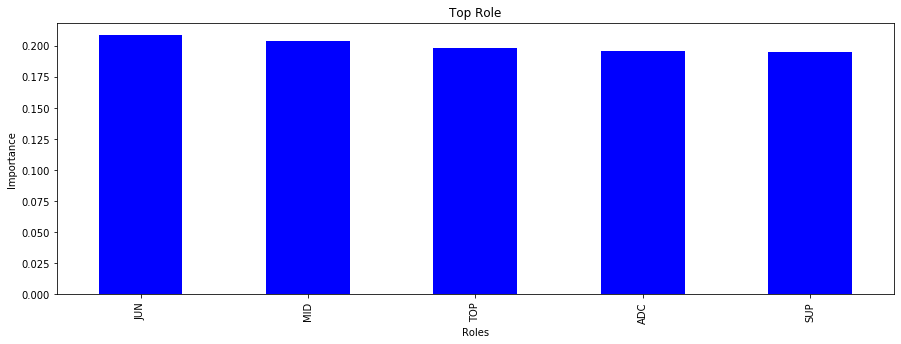

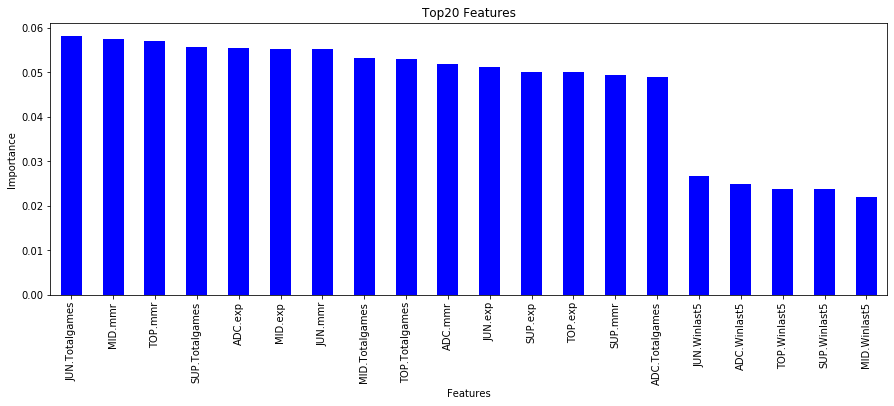

In [26]:
def feature_importance(mod="RFC"):
    total_sets = len(matrix)
    matrix2 = np.asarray(matrix)
    df = pd.DataFrame(data=matrix2[:,:-1], 
                      columns = ["TOP.WR","TOP.Nbplayed","TOP.Winlast2","TOP.Winlast5","TOP.exp","TOP.mmr","TOP.Totalgames",
                                 "JUN.WR","JUN.Nbplayed","JUN.Winlast2","JUN.Winlast5","JUN.exp","JUN.mmr","JUN.Totalgames",
                                 "MID.WR","MID.Nbplayed","MID.Winlast2","MID.Winlast5","MID.exp","MID.mmr","MID.Totalgames",
                                 "ADC.WR","ADC.Nbplayed","ADC.Winlast2","ADC.Winlast5","ADC.exp","ADC.mmr","ADC.Totalgames",
                                 "SUP.WR","SUP.Nbplayed","SUP.Winlast2","SUP.Winlast5","SUP.exp","SUP.mmr","SUP.Totalgames"])
    Xtrain, Xtest, Ytrain, Ytest = getdata(matrix,total_sets)
    model, params = RFC()
    #meanscore, best_params, stdscore = train_modelGSC()model, params, Xtrain, Ytrain
    meanscore, best_params, stdscore = train_modelRSC(model, params, Xtrain, Ytrain)
    model.set_params(**best_params)
    model.fit(Xtrain,Ytrain)
    feat_importances = pd.Series(model.feature_importances_)
    nboffeatureperrole= 7
    role_importance_list = feat_importances.groupby(feat_importances.index // nboffeatureperrole).sum()
    role_importance = pd.Series(role_importance_list.values, index=["TOP","JUN","MID","ADC","SUP"])

    plt.figure(figsize=(15,5))
    ax = plt.gca()
    role_importance.nlargest(5).plot(kind='bar', color='blue', ax=ax)
    plt.xlabel('Roles')
    plt.ylabel('Importance')
    plt.title('Top Role')
    
    
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    feat_importances = pd.Series(model.feature_importances_, index=df.columns)
    feat_importances.nlargest(20).plot(kind='bar', color='blue', ax=ax)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top20 Features')
    
    
    
feature_importance()


### Permutation Importance

The permutation importance is an intuitive, model-agnostic method to estimate the feature importance for classifier and regression models. The approach is relatively simple and straight-forward:

Take a model that was fit to the training dataset
Estimate the predictive performance of the model on an independent dataset (e.g., validation dataset) and record it as the baseline performance
For each feature i:
randomly permute feature column i in the original dataset
record the predictive performance of the model on the dataset with the permuted column
compute the feature importance as the difference between the baseline performance (step 2) and the performance on the permuted dataset

In [27]:
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML('<h3>Permutation Importance</h3>'))


def permutation_importance(mod="RFC"):
    total_sets = len(matrix)
    matrix2 = np.asarray(matrix)
    df = pd.DataFrame(data=matrix2[:,:-1], 
                      columns = ["TOP.WR","TOP.Nbplayed","TOP.Winlast2","TOP.Winlast5","TOP.exp","TOP.mmr","TOP.Totalgames",
                                 "JUN.WR","JUN.Nbplayed","JUN.Winlast2","JUN.Winlast5","JUN.exp","JUN.mmr","JUN.Totalgames",
                                 "MID.WR","MID.Nbplayed","MID.Winlast2","MID.Winlast5","MID.exp","MID.mmr","MID.Totalgames",
                                 "ADC.WR","ADC.Nbplayed","ADC.Winlast2","ADC.Winlast5","ADC.exp","ADC.mmr","ADC.Totalgames",
                                 "SUP.WR","SUP.Nbplayed","SUP.Winlast2","SUP.Winlast5","SUP.exp","SUP.mmr","SUP.Totalgames"])
    Xtrain, Xtest, Ytrain, Ytest = getdata(matrix,total_sets)
    model, params = RFC()
    #meanscore, best_params, stdscore = train_modelGSC()model, params, Xtrain, Ytrain
    meanscore, best_params, stdscore = train_modelRSC(model, params, Xtrain, Ytrain)
    model.set_params(**best_params)
    model.fit(Xtrain,Ytrain)

    perm = PermutationImportance(model, random_state=1).fit(Xtrain, Ytrain)
    display(eli5.show_weights(perm,feature_names = df.columns.tolist()))
    
    
permutation_importance()

Weight,Feature
0.0017 ± 0.0009,TOP.exp
0.0012 ± 0.0008,TOP.Totalgames
0.0011 ± 0.0021,SUP.Totalgames
0.0007 ± 0.0014,JUN.mmr
0.0006 ± 0.0000,ADC.mmr
0.0005 ± 0.0005,SUP.mmr
0.0004 ± 0.0006,MID.exp
0.0004 ± 0.0006,TOP.mmr
0.0002 ± 0.0006,ADC.exp
0.0001 ± 0.0005,MID.mmr


### Model Score

True Positives : predicted positive and actual positive
<br>
True Negatives : predicted negative and actual negative
<br>
False Positives : predicted positive and actual negative
<br>
False Negatives : predicted negative and actual positive


__Accuracy :__ 

Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations
<br>
Acc = (tp + tn) / (p + n)

__Precision :__ 

Out of those predicted positive, how many of them are actual positive.
<br>
Precision : tp / (tp + fp)

__Recall:__ 

How many of the Actual Positives our model capture through labeling it as Positive (True Positive)
<br>
Recall : tp / (tp + fn)

__F1:__ 

F1 Score is needed when you want to seek a balance between Precision and Recall
<br>
F1 : 2 tp / (2 tp + fp + fn)

__Kappa :__

__ROC AUC :__

TPR = True Positive Rate = Recall = Sensitivity = tp / (tp + fn)
Specificity = tn / (tn + fp)
FPR = 1 - Specificity


,LR,RFC,GBC,MLPC
Accuracy,0.503536,0.749646,0.731259,0.721358
Precision,0.448916,0.736334,0.742236,0.731092
Recall,0.455975,0.706790,0.690751,0.720994
F1,0.452418,0.721260,0.715569,0.726008
ROC AUC,0.499196,0.746345,0.730417,0.721367
Kappa,-0.001606,0.494218,0.461500,0.442583


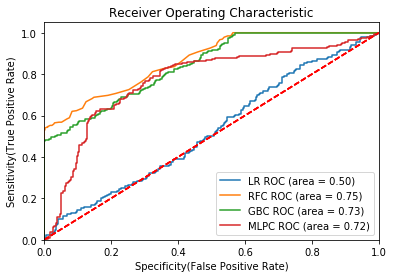

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn import metrics

plt.figure()

model_list = ['LR','RFC','GBC','MLPC']
score ={}
for mod in model_list:
    #print("Training Model : {}  - Time : {}".format(mod, datetime.datetime.now()))
    Xtrain, Xtest, Ytrain, Ytest = getdata(matrix,gamenumber=len(matrix))
    if mod == "LR" :
        model, params = LR()
    elif mod == "RFC" :
        model, params = RFC()
    elif mod == "GBC":
        model, params = GBC()
    elif mod == "MLPC":
        model, params = MLPC()
    elif mod == "SVC":
        model, params = SVC()
        #meanscore, best_params, stdscore = train_modelGSC()model, params, Xtrain, Ytrain
    meanscore, best_params, stdscore = train_modelRSC(model, params, Xtrain, Ytrain)
    model.set_params(**best_params)
    model.fit(Xtrain,Ytrain)
    
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(Ytest, model.predict_proba(Xtest)[:,1])
    # Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(Ytest,model.predict(Xtest))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (mod, auc))
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")


    
    # predict probabilities for test set
    yhat_probs = [i for i in model.predict(Xtest)]
    # predict crisp classes for test set
    yhat_classes = [i for i in model.predict(Xtest)]
    # reduce to 1d array
    #yhat_probs = yhat_probs[:, 0]
    #yhat_classes = yhat_classes[:, 0]

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(Ytest, yhat_classes)
    # precision tp / (tp + fp)
    precision = precision_score(Ytest, yhat_classes)
    # recall: tp / (tp + fn)
    recall = recall_score(Ytest, yhat_classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Ytest, yhat_classes)

    # kappa
    kappa = cohen_kappa_score(Ytest, yhat_classes)
    # ROC AUC
    auc = roc_auc_score(Ytest, yhat_probs)
    # confusion matrix
    confusion = confusion_matrix(Ytest, yhat_classes)

    score[mod] = {'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1':f1,'ROC AUC':auc,'Kappa':kappa}
display(pd.DataFrame.from_dict(score))
plt.show()   # Display
